# __NBME - Score Clinical Patient Notes__ EDA

## __Import the libraries__

In [1]:
import os
import spacy
import warnings
import wordcloud
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## __Accure the data__

In [2]:
train = pd.read_csv('../input/nbme-score-clinical-patient-notes/train.csv')
test = pd.read_csv('../input/nbme-score-clinical-patient-notes/test.csv')
features = pd.read_csv('../input/nbme-score-clinical-patient-notes/features.csv')
patients_notes = pd.read_csv('../input/nbme-score-clinical-patient-notes/patient_notes.csv')
submission = pd.read_csv('../input/nbme-score-clinical-patient-notes/sample_submission.csv')
warnings.filterwarnings('ignore')

## __Data Analysis__

#### __Train Data__

📌 Observations in Train Data:
* There are total of 6 columns and 146300 rows in train data.
* Train data contain 85800 observation with 0 missing values.
* 10 unique cases and 1000 unique patient ids are present.
* Multilple annotations and locations are present in single rows.( More Discussed in below sections )

__Column Discription__
* __id__ - Unique identifier for each patient note / feature pair.
* __pn_num__ - The patient note annotated in this row.
* __feature_num__ - The feature annotated in this row.
* __case_num__ - The case to which this patient note belongs.
* __annotation__ - The text(s) within a patient note indicating a feature. A feature may be indicated multiple times within a single note.
* __location__ - Character spans indicating the location of each annotation within the note. Multiple spans may be needed to represent an annotation, in which case the spans are delimited by a semicolon ;.

In [3]:
print(f'\033[92mNumber of rows in train data: {train.shape[0]}')
print(f'\033[94mNumber of columns in train data: {train.shape[1]}')
print(f'\033[91mNumber of values in train data: {train.count().sum()}')
print(f'\033[93mNumber missing values in train data: {sum(train.isna().sum())}')
train.head()

Number of rows in train data: 14300
Number of columns in train data: 6
Number of values in train data: 85800
Number missing values in train data: 0


,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


#### __Test data__

In [4]:
print(f'\033[92mNumber of rows in test data: {test.shape[0]}')
print(f'\033[94mNumber of columns in test data: {test.shape[1]}')
print(f'\033[91mNumber of values in test data: {test.count().sum()}')
print(f'\033[93mNumber missing values in test data: {sum(test.isna().sum())}')
test.head()

Number of rows in test data: 5
Number of columns in test data: 4
Number of values in test data: 20
Number missing values in test data: 0


,id,case_num,pn_num,feature_num
0,00016_000,0,16,0
1,00016_001,0,16,1
2,00016_002,0,16,2
3,00016_003,0,16,3
4,00016_004,0,16,4


#### __Patients notes data__

📌  __Observations in Patient Notes Data:__
* There are total of 3 columns and 42146 rows in Patient Notes data.
* Patient Notes Data contain 126438 observation with 0 missing values.
* Number of patients per case are unequally distributed with Case 3 having maximum and Case 1 having minimum.
* Average length of ph_history column is 818.17.
* There are total of 1000 unique patients

__Column Description__

* pn_num - A unique identifier for each patient note.
* case_num - A unique identifier for the clinical case a patient note represents.
* pn_history - The text of the encounter as recorded by the test taker.

In [5]:
print(f'\033[92mNumber of rows in patients notes data: {patients_notes.shape[0]}')
print(f'\033[94mNumber of columns in patients notes data: {patients_notes.shape[1]}')
print(f'\033[91mNumber of values in patients notes data: {patients_notes.count().sum()}')
print(f'\033[93mNumber missing values in patients notes data: {sum(patients_notes.isna().sum())}')
patients_notes.head()

Number of rows in patients notes data: 42146
Number of columns in patients notes data: 3
Number of values in patients notes data: 126438
Number missing values in patients notes data: 0


,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


__Sample Patient Note__

In [6]:
patients_notes['pn_history'][1]

'17 yo male with recurrent palpitations for the past 3 mo lasting about 3 - 4 min, it happened about 5 - 6 times since the beginning. One time durign a baskeball game two days ago light headedness, pressure in the chest, catching breath, but no fainting. During teh episodes no sweating. No diarrhea, no heat intolerance, no weight loss. Has tried aterol to be able to better concentrate, has received it from his roommate. .'

__Patient Notes Distribution__

In [7]:
notes_counts = patients_notes.groupby("case_num").count()
fig = px.bar(data_frame =notes_counts, 
             x = notes_counts.index,
             y = 'pn_num' , 
             color = "pn_num",
             color_continuous_scale="Emrld") 
fig.update_layout(title = {
        'text': 'Distribution of patient notes for each case',
        'y':0.95,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'} ,
                   xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1,2, 3, 4,5, 6,7,8,9],
        ticktext = ['Case 0', 'Case 1', 'Case 2', 'Case 3', 'Case 4', 'Case 5', 'Case 6', 'Case 7', 'Case 8', 'Case 9']),
                  template = "plotly_white")
fig.show()

__Patient Notes Length Distribution__

In [8]:
all_notes = []
all_notes_len = []
for notes in patients_notes['pn_history']:
    all_notes.append(notes)
    all_notes_len.append(len(notes))
print("Average length of Patient History - ",np.mean(all_notes_len))
fig = px.histogram(x = all_notes_len,  marginal="violin",nbins = 100)
fig.update_xaxes(title = "Lenght of patient Notes")
fig.show()

Average length of Patient History -  818.1768139325203


__Unique patient count__

In [9]:
print("Unique Patient Count in train data : ",len(train["pn_num"].value_counts()))

Unique Patient Count in train data :  1000


#### __Features Data__

📌  __Observations in Features Data__
* There are total of 3 columns and 143 rows in Features data.
* Patient Notes Data contain 429 observation with 0 missing values.
* Number of patients per case are unequally distributed with Case 5 and Case 8 having maximum and Case 7 having minimum.
* Average length of feature_text column is 23.20.

In [10]:
print(f'\033[92mNumber of rows in feature data: {features.shape[0]}')
print(f'\033[94mNumber of columns in feature data: {features.shape[1]}')
print(f'\033[91mNumber of values in feature data: {features.count().sum()}')
print(f'\033[93mNumber missing values in feature data: {sum(features.isna().sum())}')
features.head()

Number of rows in feature data: 143
Number of columns in feature data: 3
Number of values in feature data: 429
Number missing values in feature data: 0


,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


__Sample Feature text__

In [11]:
features["feature_text"][0]

'Family-history-of-MI-OR-Family-history-of-myocardial-infarction'

__Feature Distribution__

In [12]:
feature_counts = features.groupby("case_num").count()
fig = px.bar(data_frame =feature_counts, 
             x = feature_counts.index,
             y = 'feature_num' , 
             color = "feature_num",
             color_continuous_scale="Emrld") 
fig.update_layout(title = {
        'text': 'Distribution of Features for each case',
        'y':0.95,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'} ,
                   xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1,2, 3, 4,5, 6,7,8,9],
        ticktext = ['Case 0', 'Case 1', 'Case 2', 'Case 3', 'Case 4', 'Case 5', 'Case 6', 'Case 7', 'Case 8', 'Case 9']),
                  template = "plotly_white")
fig.show()

__Feature Length Distribution__

In [13]:
all_feat = []
all_feat_len = []
for notes in features['feature_text']:
    all_feat.append(notes)
    all_feat_len.append(len(notes))
print("Average length of Patient History - ",np.mean(all_feat_len))
fig = px.histogram(x = all_feat_len,  marginal="violin",nbins = 200)
fig.update_layout(template="plotly_white")
fig.update_xaxes(title = "Lenght of Features")
fig.show()

Average length of Patient History -  23.20979020979021


#### __Annotation Analysis__

For every unqiue pat_num there are several rows depecting several anotations in patient notes.

__Empty Annotation count__

In [14]:
print("Number of Empty annotions and locations = ", sum(train["location"] == '[]'))

Number of Empty annotions and locations =  4399


__Annotation Count Distribution__

In [15]:
train["location"] = train["location"].apply(eval)
train['annotation'] = train['annotation'].apply(eval)
train["annot_count"] = 0
for i in range(len(train)):
    train["annot_count"][i] = len(train["annotation"][i])
total_annot = 0
for idx in train["annot_count"].value_counts().sort_index().index:
    total_annot += train["annot_count"].value_counts().sort_index()[idx] * idx
print(f'\033[92mTotal number of Annotations is train data  : ' , total_annot)
print(f'\033[94mAnnotation count per row: ')
print(f'\033[94m',train["annot_count"].value_counts().sort_index())

Total number of Annotations is train data  :  12234
Annotation count per row: 
 0    4399
1    8181
2    1296
3     287
4      99
5      27
6       9
7       1
8       1
Name: annot_count, dtype: int64


In [16]:
fig = px.bar(data_frame =train, 
             x = train["annot_count"].value_counts().sort_index().index,
             y = train["annot_count"].value_counts().sort_index() , 
             color = train["annot_count"].value_counts().sort_index(),
             color_continuous_scale="Emrld") 
fig.update_xaxes(title ="Number of Annotations")
fig.update_yaxes(title ="Number of Rows")
fig.update_layout(title = {
        'text': 'Number of Annotations per row',
        'y':0.95,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'} ,
                   
                  template = "plotly_white")
fig.show()

__Annotation Length Distribution__

In [17]:
annot_lengths = []
all_annot_words = []
for annot in train["annotation"]:
    for words in annot:
        annot_lengths.append(len(words))
        all_annot_words.append(words)
print("Average length of Annotations - ",np.mean(annot_lengths))
fig = px.histogram(x = annot_lengths,  marginal="violin",nbins = 300)
fig.update_layout(template="plotly_white")
fig.update_xaxes(title = "Lenght of Annotation")
fig.show()

Average length of Annotations -  16.528445316331535


__Annotation Visualisation (SPACY)__

In [18]:
patient_df = train[train["pn_num"] == 74087]
location  = patient_df["location"]
annotation = patient_df["annotation"]
start_pos = []
end_pos = []
for i in location:
    for j in i:
        start_pos.append(j.split()[0])
        end_pos.append(j.split()[1])
        
ents = []
for i in range(len(start_pos)):
    ents.append({
        'start': int(start_pos[i]), 
        'end' : int(end_pos[i]),
        "label" : "Annotation"
    })
doc = {
    'text' : patients_notes[patients_notes["pn_num"] == 74087]["pn_history"].iloc[0],
    "ents" : ents
}
colors = {"Annotation" :"linear-gradient(90deg, #aa9cfc, #fc9ce7)" } 
options = {"colors": colors}
spacy.displacy.render(doc, style="ent", options = options , manual=True)

#### __WORD CLOUDS__

__WORDCLOUD for Patient history__

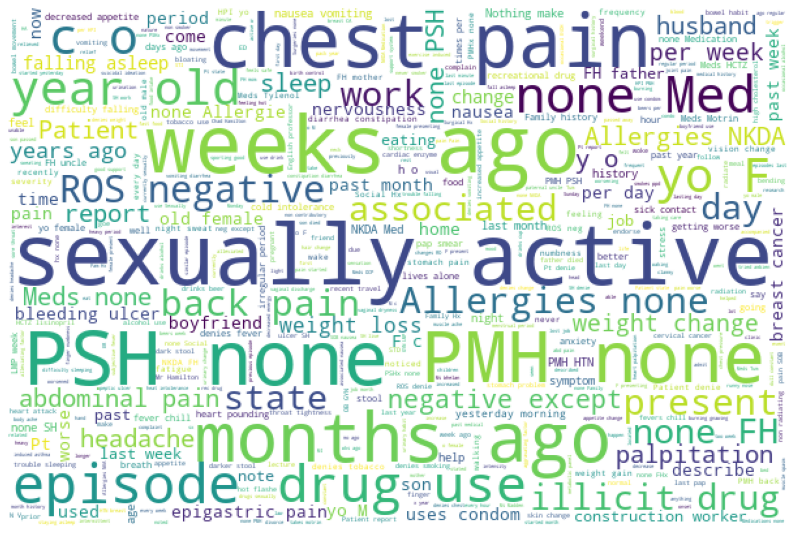

In [19]:
wordcloud_notes = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=120, max_words=5000,
                      width = 600, height = 400,
                      background_color='white').generate(" ".join(all_notes))
fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(wordcloud_notes, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud_notes)

__WORDCLOUD for Features__

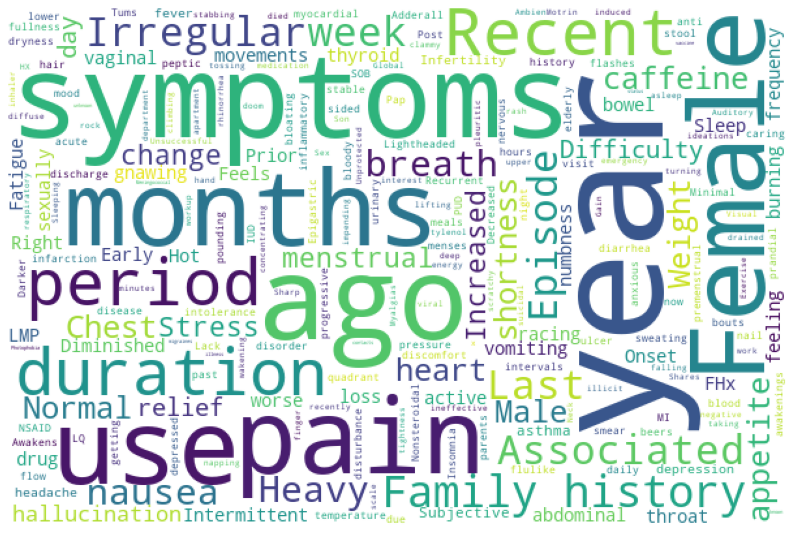

In [20]:
wordcloud_feat = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=120, max_words=5000,
                      width = 600, height = 400,
                      background_color='white').generate(" ".join(all_feat))
fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(wordcloud_feat, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud_feat)

__WORDCLOUD for Annotations__

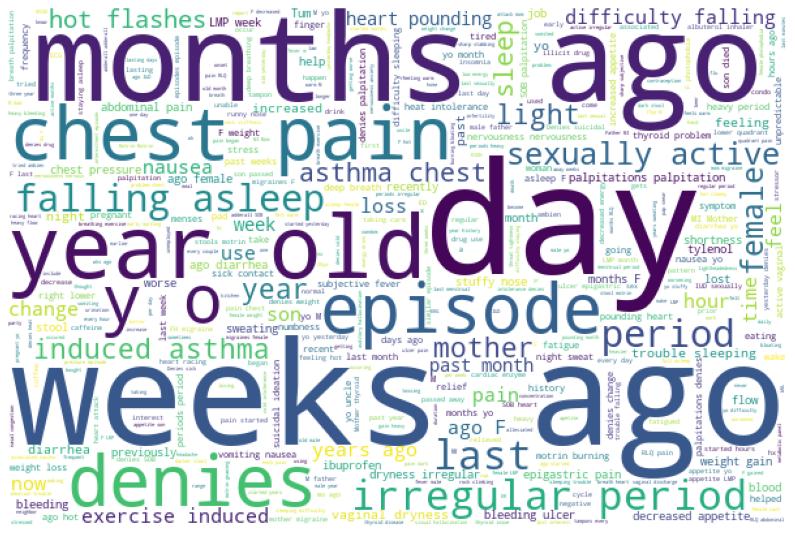

In [21]:
wordcloud_annot = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=120, max_words=5000,
                      width = 600, height = 400,
                      background_color='white').generate(" ".join(all_annot_words))
fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(wordcloud_annot, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud_annot)

__WORDCLOUD for two characters words in Patient notes__

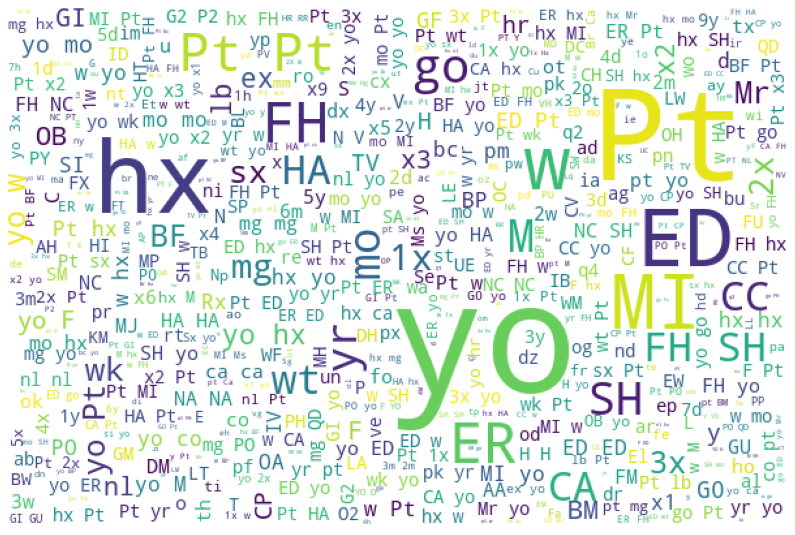

In [22]:
two  = []
for note in all_notes:
    for word in note.split():
        if len(word)==2:
            two.append(word)
wordcloud_two_chars = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=120, max_words=len(set(two)),
                      width = 600, height = 400,
                      background_color='white').generate(" ".join(two ))
fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(wordcloud_two_chars, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud_two_chars)